## Stents snRNA data subclustering

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os, sys, string

sc.set_figure_params(vector_friendly=False, fontsize=18)
import leidenalg
import pandas as pd
import numpy as np
import anndata

from scipy.io import mmwrite
import matplotlib.pyplot as plt

from typing import Tuple, Union, List, Dict, Callable
import os
import gzip
import shutil
import inspect
import h5py
import anndata
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(anndata.__version__)
print(sc.__version__)
print(h5py.__version__)

0.7.6
1.8.1
3.7.0


In [10]:
home      = "/Users/shayat/Documents/Aachen/projects/stents/"
datahome  = home+ "data/"
resulthome= home+ "results/"

In [5]:
filename2  = "scvi_output.h5ad"
cluster_file= filename2[:-5]+'_clustered.h5ad'

## START

In [23]:
adata    = sc.read_h5ad(resulthome+"scvi_output_clustered_subs.h5ad")

In [24]:
#adata = adata[adata.obs["leiden0.3"] != "12 : neuronal_trash"].copy()

In [25]:
adata.obs.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.1,seurat_clusters,cc,integrated_snn_res.0.2,cell_type,cluster,...,n_counts,n_genes,scvi_library_size,solo_singlet_logit_prob,solo_doublet_logit_prob,leiden0.3,barcode,subcluster,main_class,subcluster_name
AAACCCAAGAACTTCC-1,pbmc3k,3898.0,1296,5.977424,0,0,case,0,B-cell,B-cell,...,3898.0,1296,1.842570,2.298886,-2.189409,0 : Bcells_1,AAACCCAAGAACTTCC-1,1.0,bcell,bcell_1.0
AAACCCACACCTGCGA-1,pbmc3k,5203.0,1858,8.072266,6,7,case,7,Endothelial1,Endothelial1,...,5203.0,1858,3.739815,4.349167,-4.120618,7 : EC1,AAACCCACACCTGCGA-1,0.0,ec,ec_0.0


In [26]:
adata

AnnData object with n_obs × n_vars = 5117 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3', 'barcode', 'subcluster', 'main_class', 'subcluster_name'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'subcluster_name_colors'

In [27]:
res = 0.3

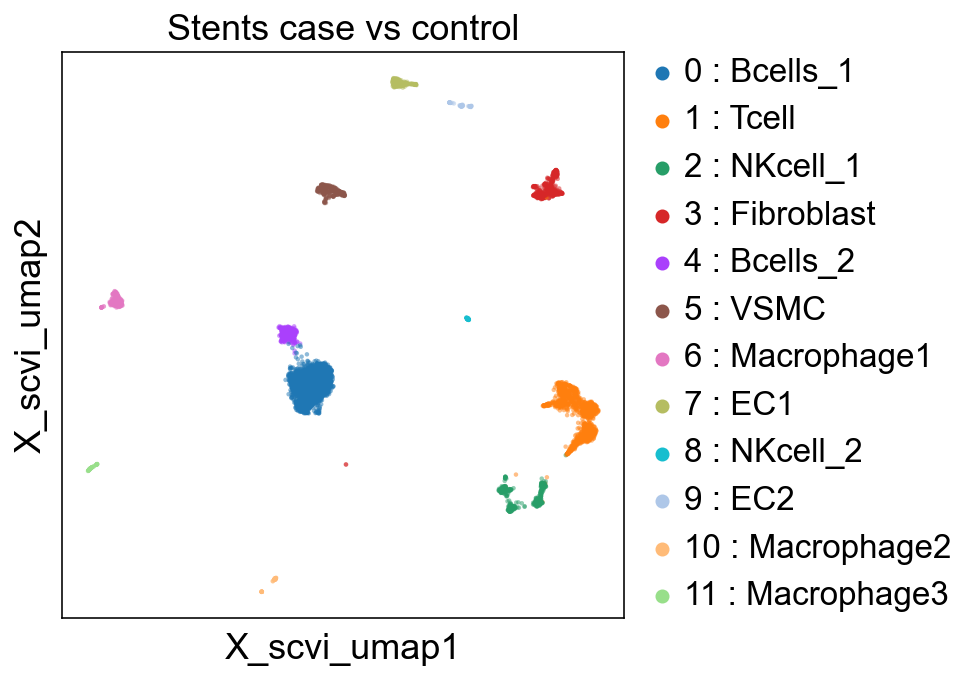

In [28]:
# check out how it looks by tissue
plt.figure(figsize=(5, 5))

#sc.pl.embedding(adata, basis='X_scvi_umap', color='cell_type', ax=plt.gca(), size=20, alpha=0.5, show=False)
sc.pl.embedding(adata, basis='X_scvi_umap', color='leiden'+str(res), ax=plt.gca(), size=20, alpha=0.5, show=False)
plt.title('Stents case vs control')
#plt.xlabel('UMAP 1')
#plt.ylabel('UMAP 2')
plt.show()

In [29]:
adata

AnnData object with n_obs × n_vars = 5117 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3', 'barcode', 'subcluster', 'main_class', 'subcluster_name'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'subcluster_name_colors'

/var/folders/mj/150fcld105b9nxwtjxcvhy8c0000gn/T/ipykernel_1550/1684889185.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 864x864 with 0 Axes>

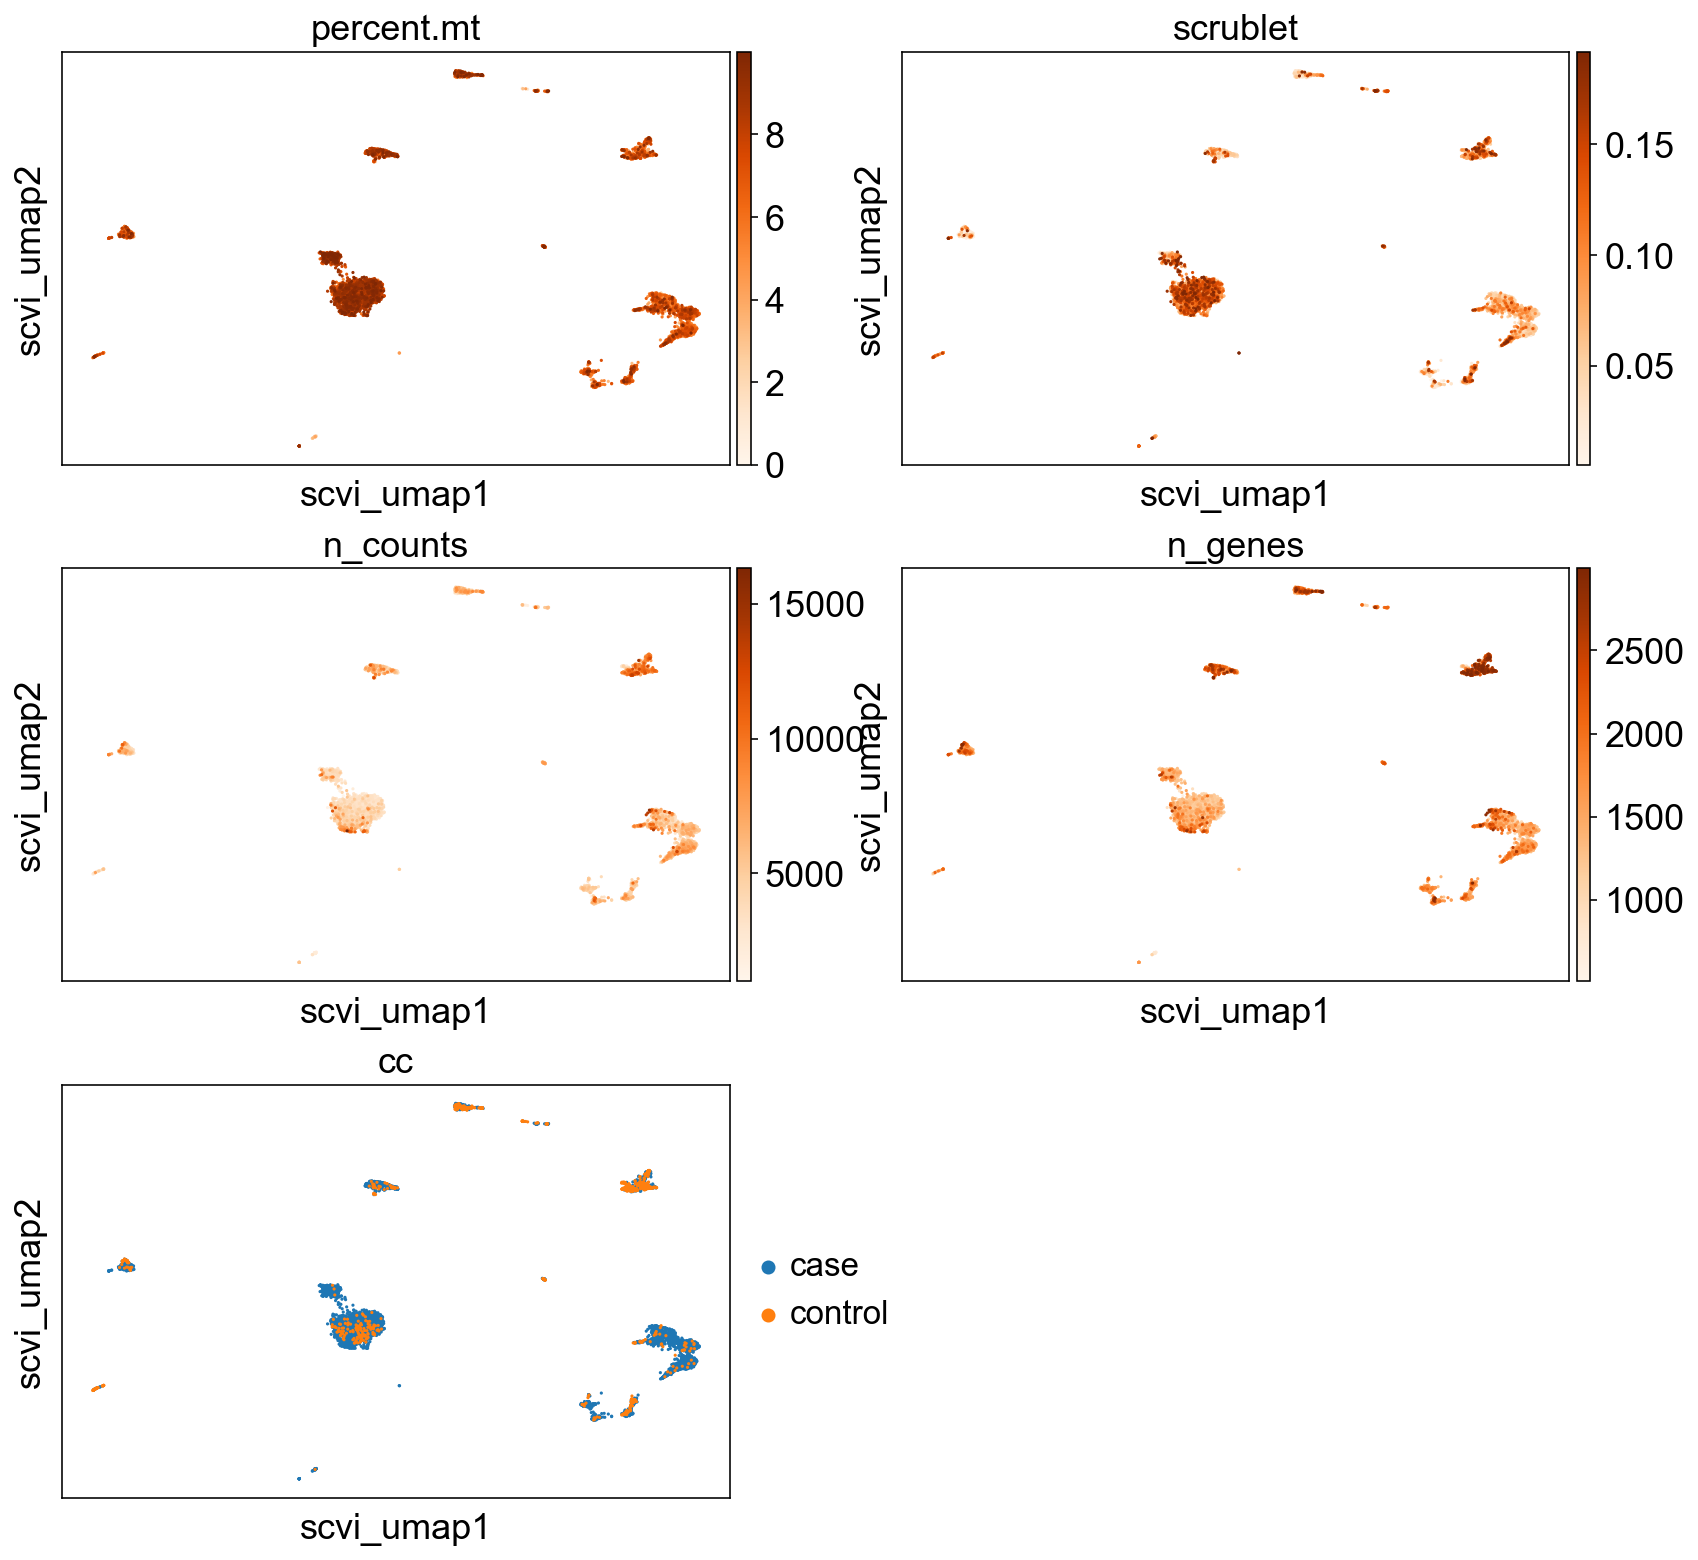

In [31]:
f = plt.figure(figsize = (12,12))

sc.pl.embedding(adata, basis='scvi_umap', color=['percent.mt', 'scrublet', 'n_counts', 'n_genes', \
                                           'cc'], ncols=2,
                color_map='Oranges', size=10, show=False)
plt.tight_layout()
#plt.savefig('stentes_QC_features.pdf', bbox_inches='tight')

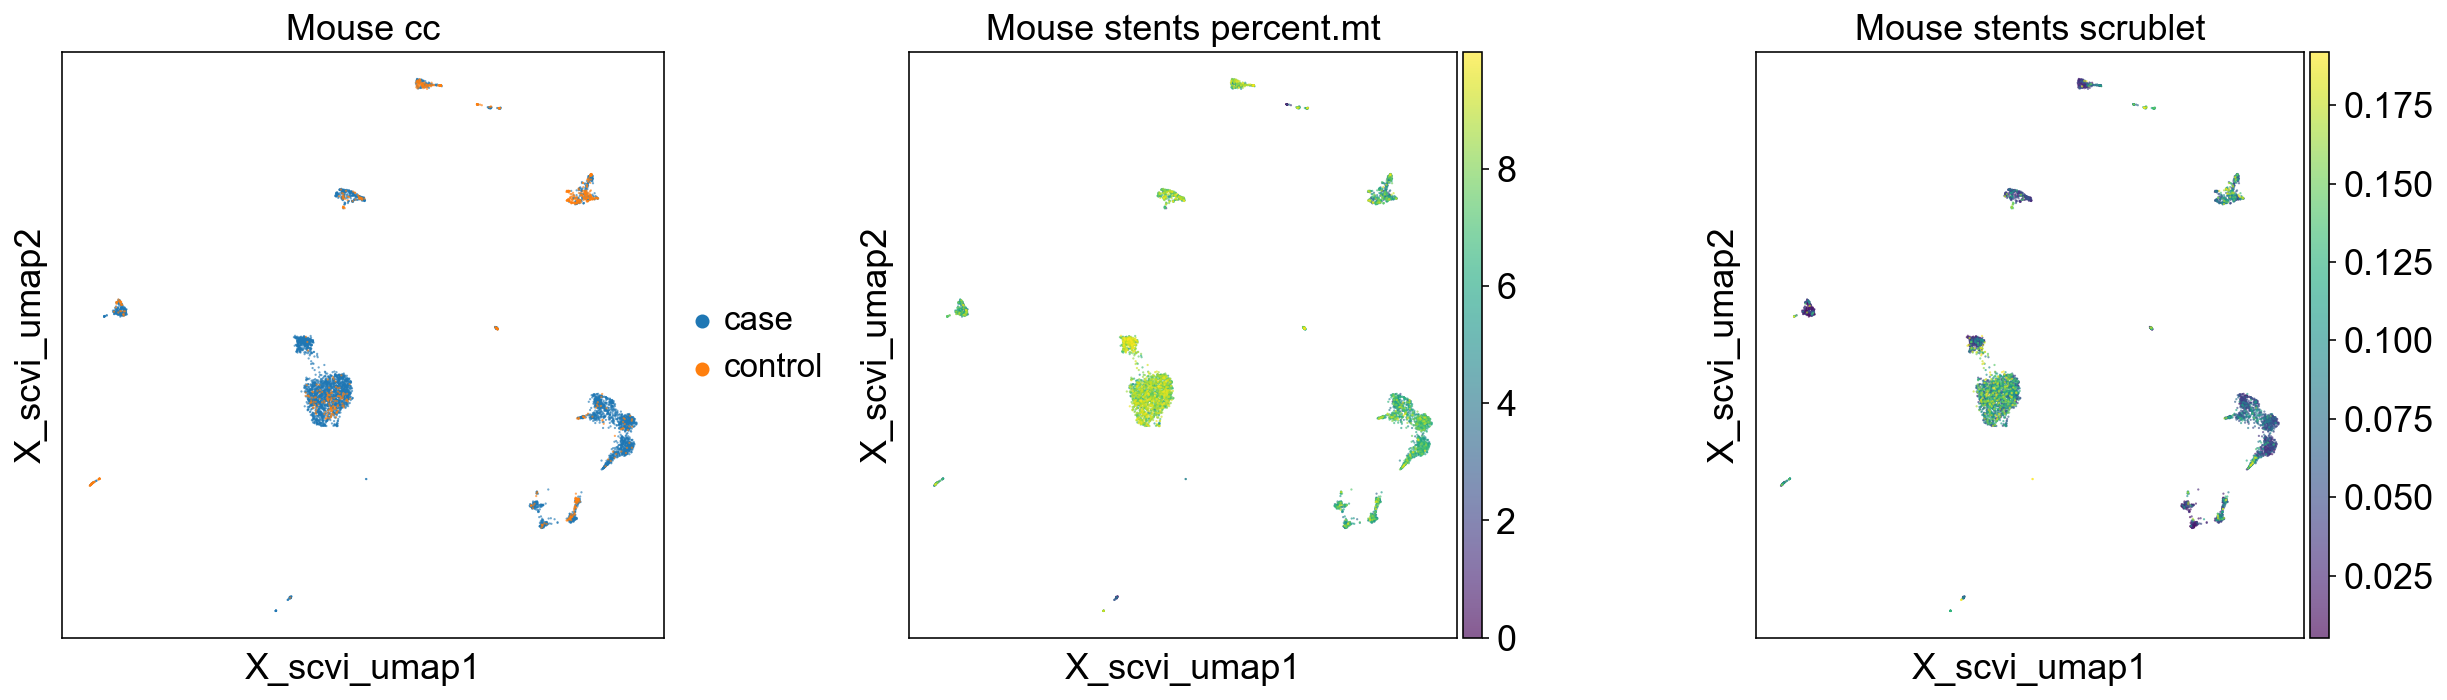

In [33]:
myrep = "X_scvi_umap"

plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
sc.pl.embedding(adata, basis=myrep, color='cc', ax=plt.gca(), show=False, alpha=0.64, size=5)
plt.title('Mouse cc')


plt.subplot(1, 3, 2)
sc.pl.embedding(adata, basis=myrep, color='percent.mt', ax=plt.gca(), show=False, alpha=0.64, size=5)
plt.title('Mouse stents percent.mt')

plt.subplot(1, 3, 3)
sc.pl.embedding(adata, basis=myrep, color='scrublet', ax=plt.gca(), show=False, alpha=0.64, size=5)
plt.title('Mouse stents scrublet')
plt.tight_layout()

plt.show()

In [34]:
print(Counter(adata.obs["leiden"+str(res)]))

Counter({'0 : Bcells_1': 1682, '1 : Tcell': 1289, '2 : NKcell_1': 477, '3 : Fibroblast': 384, '4 : Bcells_2': 327, '5 : VSMC': 272, '6 : Macrophage1': 242, '7 : EC1': 190, '8 : NKcell_2': 73, '9 : EC2': 71, '10 : Macrophage2': 58, '11 : Macrophage3': 52})


In [35]:
# Check to make sure it's still counts
adata[:,'Gsn'].X.todense()

matrix([[1.],
        [0.],
        [1.],
        ...,
        [1.],
        [0.],
        [2.]], dtype=float32)

In [36]:
adata.var.head()

,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Vom2r6,False,NaN,0.001944,0.001940,0.920259,0
Raet1e,False,NaN,0.001166,0.001554,0.612056,0
AABR07000109.1,False,NaN,0.000777,0.000777,0.471709,0
Ulbp1,False,NaN,0.016521,0.019362,1.018596,0
AABR07000147.1,False,NaN,0.000194,0.000194,0.500227,0


In [38]:
myclusters = adata.obs["leiden"+str(res)].drop_duplicates().values.tolist()

In [39]:
print(myclusters)

['0 : Bcells_1', '7 : EC1', '1 : Tcell', '5 : VSMC', '2 : NKcell_1', '4 : Bcells_2', '6 : Macrophage1', '10 : Macrophage2', '11 : Macrophage3', '9 : EC2', '8 : NKcell_2', '3 : Fibroblast']


In [40]:
## Choose cluster of interset for further subclustering

clusters_of_interest = ['5 : VSMC']
cluster_key          = "leiden"+str(res)

In [41]:
bdata = adata[adata.obs[cluster_key].isin(clusters_of_interest)].copy()

bdata

AnnData object with n_obs × n_vars = 272 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3', 'barcode', 'subcluster', 'main_class', 'subcluster_name'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'subcluster_name_colors',

In [44]:
pd.crosstab(bdata.obs["orig.ident"], bdata.obs["cc"])

cc,case,control
orig.ident,,
pbmc3k,232,40


In [48]:
## make a copy if further filtering is needed
tmp_bdata = bdata.copy()

In [49]:
tmp_bdata

AnnData object with n_obs × n_vars = 272 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3', 'barcode', 'subcluster', 'main_class', 'subcluster_name'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'subcluster_name_colors',

In [50]:
## Seurat V3 needs raw counts
sc.pp.highly_variable_genes(tmp_bdata, n_top_genes = 2000, flavor = 'seurat_v3')

In [37]:
sc.pp.normalize_total(tmp_bdata, target_sum=1e4)
sc.pp.log1p(tmp_bdata)

In [38]:
cdata = tmp_bdata[:, tmp_bdata.var.highly_variable]

In [39]:
# choose if you want to regress out some co-variates
sc.pp.regress_out(cdata, ['nCount_RNA', 'percent.mt'])

In [40]:
#sc.pp.scale(cdata, max_value=10)

In [41]:
sc.tl.pca(cdata, svd_solver='arpack', n_comps = 50)

In [5]:
from harmony import harmonize

In [6]:
import harmony as hm
print(hm.__version__)

0.1.6


In [42]:
## Choose variable for batch-effect correction

#Z = harmonize(cdata.obsm['X_pca'], cdata.obs, batch_key = ['batch', 'orig_ident'], max_iter_harmony = 40)
#Z = harmonize(cdata.obsm['X_pca'], cdata.obs, batch_key = ['patient', 'batch'], max_iter_harmony = 40)
Z = harmonize(cdata.obsm['X_pca'], cdata.obs, batch_key = ['cc'], max_iter_harmony = 40)
#Z = harmonize(cdata.obsm['X_pca'], cdata.obs, batch_key = ['patient'], max_iter_harmony = 40)

	Initialization is completed.
	Completed 1 / 40 iteration(s).
	Completed 2 / 40 iteration(s).
	Completed 3 / 40 iteration(s).
	Completed 4 / 40 iteration(s).
	Completed 5 / 40 iteration(s).
Reach convergence after 5 iteration(s).


In [43]:
tmp_bdata.obsm['X_pca_harmony'] = Z

In [44]:
sc.pp.neighbors(tmp_bdata, n_neighbors=10, n_pcs=50, use_rep = 'X_pca_harmony',\
                metric = 'cosine', key_added = 'PC_harmony')

In [45]:
sc.tl.umap(tmp_bdata, neighbors_key = 'PC_harmony')#, min_dist = 0.01)

In [49]:
res_list = [0.1]
for res in res_list:
    sc.tl.leiden(tmp_bdata, resolution = res, key_added = 'leiden'+str(res), neighbors_key = 'PC_harmony')

<AxesSubplot:title={'center':'leiden0.1'}, xlabel='UMAP1', ylabel='UMAP2'>

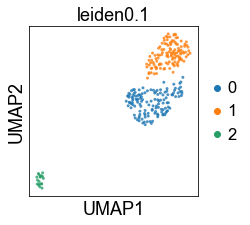

In [50]:
res = 0.1
sc.pl.embedding(tmp_bdata, basis='umap', color='leiden'+str(res), ax=plt.gca(), show=False, alpha=0.8, size=35)

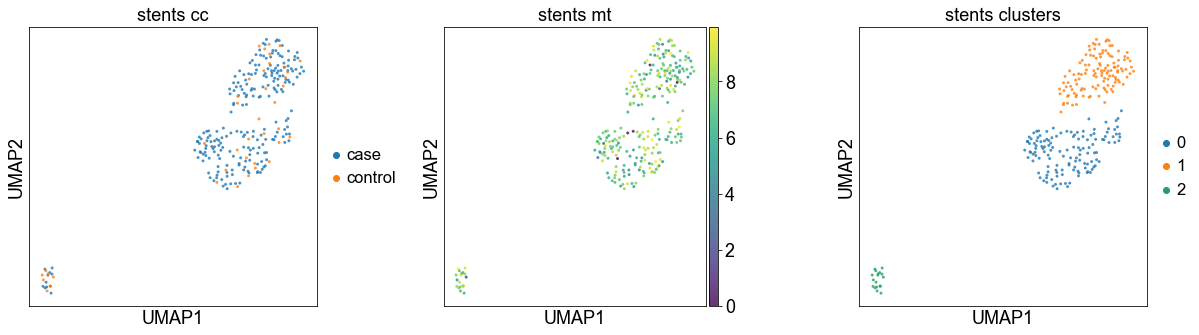

In [48]:
myrep = "umap"

plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
sc.pl.embedding(tmp_bdata, basis=myrep, color='cc', ax=plt.gca(), show=False, alpha=0.8, size=35)
plt.title('stents cc')

plt.subplot(1, 3, 2)
sc.pl.embedding(tmp_bdata, basis=myrep, color='percent.mt', ax=plt.gca(), show=False, alpha=0.8, size=35)
plt.title('stents mt')

plt.subplot(1, 3, 3)
sc.pl.embedding(tmp_bdata, basis=myrep, color='leiden'+str(res), ax=plt.gca(), show=False, alpha=0.8, size=35)
plt.title('stents clusters')

plt.tight_layout()

plt.show()

In [149]:
pd.crosstab(tmp_bdata.obs["leiden"+str(res)], tmp_bdata.obs["cc"])

cc,case,control
leiden0.5,,
0,108,29
1,112,6
2,95,7
3,62,37
4,52,22
5,9,3
6,8,0


In [136]:
min_in_group_fraction=0.1
max_out_group_fraction=0.5
min_log_fold_change=1.

print("Finding markers")
sc.tl.rank_genes_groups(tmp_bdata,
                                groupby='leiden'+str(res),
                                key_added='rank_genes_groups' + str(res),
                                method='wilcoxon',
                                use_raw=False)
    

print("Filtering markers")
sc.tl.filter_rank_genes_groups(tmp_bdata,
                               groupby='leiden'+str(res),
                               key='rank_genes_groups' + str(res),
                               key_added='filter_rank_genes_groups' + str(res),
                               min_in_group_fraction=min_in_group_fraction,
                               min_fold_change=min_log_fold_change,
                               max_out_group_fraction=max_out_group_fraction,
                               use_raw=False)

Finding markers
Filtering markers


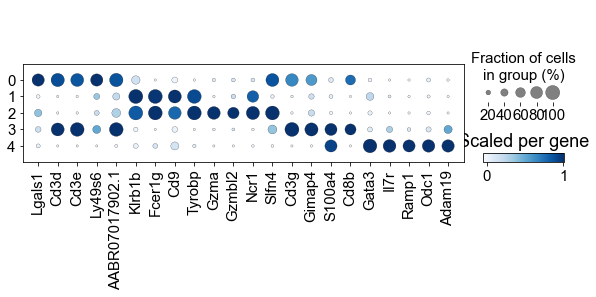

In [138]:
# plot marker genes
#res = 0.5

plt.rcParams.update({'font.size': 18})
n = 5

marker_key = 'rank_genes_groups' + str(res)
marker_key = 'filter_rank_genes_groups' + str(res)

marker_genes = np.array(tmp_bdata.uns[marker_key]['names'][:(n + 5)].tolist(), 
                        dtype=str).transpose()

unique_markers = []

for k in range(marker_genes.shape[0]):
    i = 0
    for g in marker_genes[k, :]:
        if i < n and g not in unique_markers and g != 'nan' and g != 'Malat1':  # exclude malat1 or others based on data
            unique_markers.append(g)
            i += 1

#unique_markers.append("PTPRC")

sc.pl.dotplot(adata,  var_names=unique_markers,groupby='leiden'+str(res), \
                                 use_raw=False, vmin=-0.05,
              vmax=1.01,cmap='bwr', standard_scale='var', show=False)

plt.title('Scaled per gene')
plt.show()

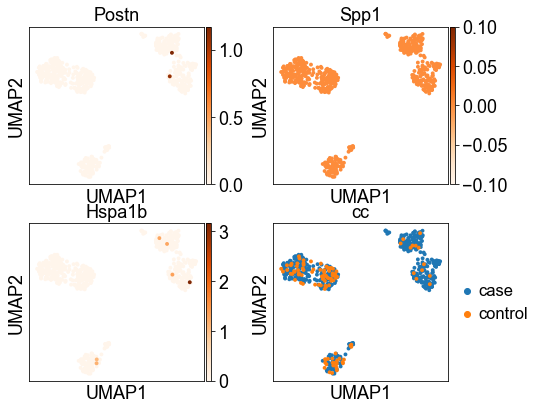

In [139]:
genenames =  ["Postn", "Spp1", "Hspa1b", "cc"]#: continue
sc.pl.embedding(tmp_bdata, basis='umap', color=genenames, color_map='Oranges', size=60, ncols=2)

In [141]:
# copy back over to adata
try:
    bdata.obsm['X_umap'] = tmp_bdata.obsm['X_umap']
except:
    print('Failed in copying over X_umap data')
try:
    bdata.obsm['X_pca_harmony'] = tmp_bdata.obsm['X_pca_harmony']
except:
    print('Failed in copying over X_pca_harmony data')
try:
    bdata.obs['leiden' + str(res)] = tmp_bdata.obs['leiden' + str(res)]
except:
    print('Failed in copying over leiden clustering data')
try:
    bdata.uns['rank_genes_groups' + str(res)] = tmp_bdata.uns['rank_genes_groups' + str(res)]
except:
    print('Failed in copying over rank_genes_groups data')
try:
    bdata.uns['filter_rank_genes_groups' + str(res)] = tmp_bdata.uns['filter_rank_genes_groups' + str(res)]
except:
    print('Failed in copying over filter_rank_genes_groups data')

if '__is_in_cluster__' in bdata.obs.keys():
    del bdata.obs['__is_in_cluster__']

In [152]:
bdata

AnnData object with n_obs × n_vars = 550 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'cc_colors'
    obsm: 'PCA', 'UMAP', 'X_scvi', 'X_scvi_umap', 'X_umap', 'X_pca_harm

In [144]:
del bdata.uns["filter_rank_genes_groups0.3"]

In [153]:
mytitle = "stents_nk_"+str(res)+"subcluster"
print(mytitle)

stents_nk_0.3subcluster


In [154]:
bdata.write(datahome + mytitle+ ".h5ad")

## Get Scanpy based logFC for marker genes using the default method

In [155]:
myclusters = bdata.obs["leiden" + str(res)].unique().tolist()
print(myclusters)

adatas = []
for mycluster in myclusters:
    tmp = sc.get.rank_genes_groups_df(bdata, group=mycluster, key='rank_genes_groups' + str(res))
    tmp["ident"] = mycluster
    adatas.append(tmp)

#print(thisframe)
adata = pd.concat(adatas)
#print(adata.sample(5))

markerfilename = mytitle +'_logFC_stacked_marker_table.csv'

print(adata[adata["pvals_adj"]<0.01].sort_values(by=["ident", "logfoldchanges"], ascending=[True, False]).head())
print(adata[adata["pvals_adj"]<0.01].sort_values(by=["ident", "logfoldchanges"]).shape)
print(markerfilename)

adata[adata["pvals_adj"]<0.01].sort_values(by=["ident", "logfoldchanges"], ascending=[True, False])\
.to_csv(datahome + markerfilename)

['2', '3', '0', '4', '1']
     names     scores  logfoldchanges         pvals     pvals_adj ident
1   Lgals1  11.679858        3.251632  1.615649e-31  1.302940e-27     0
10    Sit1   9.454754        3.042094  3.237825e-21  4.017144e-18     0
5   Ly49s6  10.640360        2.980683  1.933818e-26  5.198426e-23     0
4     Cd3e  10.660213        2.867049  1.562398e-26  5.039985e-23     0
2     Cd3d  11.061308        2.861938  1.932577e-28  1.039018e-24     0
(1049, 6)
stents_nk_0.3subcluster_logFC_stacked_marker_table.csv


In [156]:
bdata

AnnData object with n_obs × n_vars = 550 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'cc_colors'
    obsm: 'PCA', 'UMAP', 'X_scvi', 'X_scvi_umap', 'X_umap', 'X_pca_harm

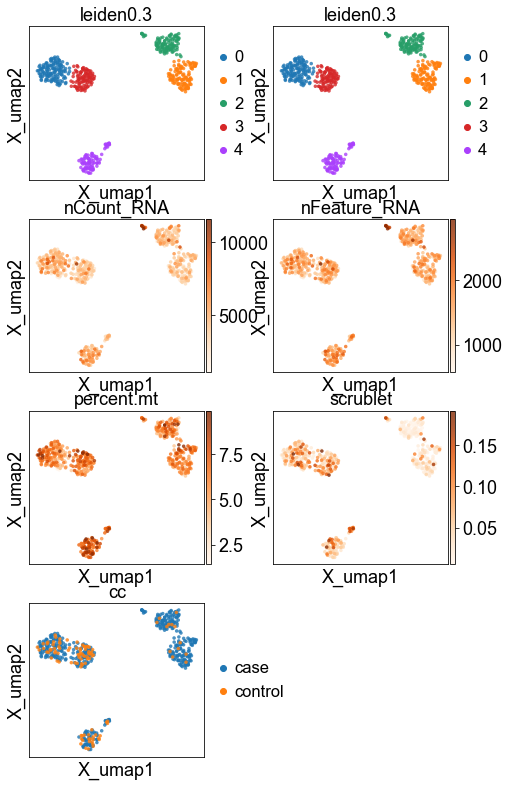

In [157]:
sc.pl.embedding(bdata, basis='X_umap', color=['leiden'+str(res), 'leiden0.3', 'nCount_RNA', 'nFeature_RNA',\
                                           'percent.mt', 'scrublet', "cc"], ncols=2,
                color_map='Oranges', size=50, alpha=0.8)

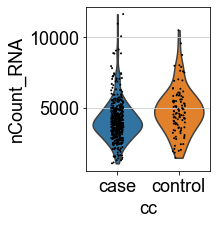

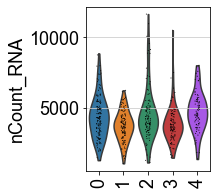

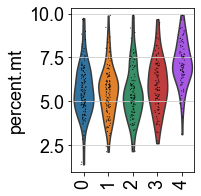

In [158]:
# Quality control - plot QC metrics
#Sample quality plots
cluster_key="leiden" + str(res)

t1 = sc.pl.violin(bdata, 'nCount_RNA', groupby='cc', size=2, log=False, cut=0, figsize=(2,2))
#t2 = sc.pl.violin(bdata, 'percent.mt', groupby='cc', figsize=(2,2))
t3 = sc.pl.violin(bdata, 'nCount_RNA', groupby=cluster_key, rotation=90)
t4 = sc.pl.violin(bdata, 'percent.mt', groupby=cluster_key, rotation=90)

In [160]:
bdata.obs[["cell_type", "cluster", "leiden0.3"]].drop_duplicates()

,cell_type,cluster,leiden0.3
AAACGCTCAACAAGAT-1,T-cell,T-cell,2
AAAGGATGTTCTCAGA-1,T-cell,T-cell,3
AACAAAGAGGCCCACT-1,T-cell,T-cell,0
AACAACCGTAGCGTTT-1,T-cell,T-cell,4
AACAAGACAGCGTACC-1,T-cell,T-cell,1


In [161]:
mykey = "cc"

In [162]:
count_df      = pd.crosstab(bdata.obs[mykey], bdata.obs["leiden" + str(res)])
mycount_adata = anndata.AnnData(X=count_df)
mycount_adata.obs[mykey] = mycount_adata.obs.index

2022-06-21 23:29:23,735 [47045] WARNING  py.warnings:109: [JupyterRequire] /opt/anaconda3/envs/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)



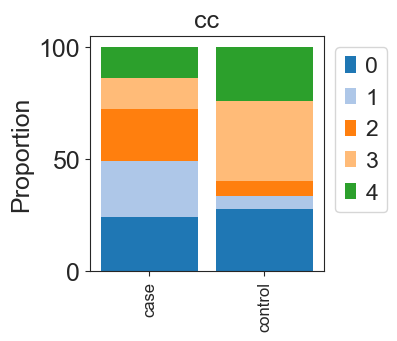

In [163]:
import warnings

from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

warnings.filterwarnings("ignore")

##visualization
viz.stacked_barplot(mycount_adata, feature_name=mykey)
plt.xticks(fontsize=12, rotation=90)
plt.show()

## Read subclustered filename

In [51]:
mytitle = "stents_Fibs_0.2subcluster" ## Change this to the subclustered filename

In [538]:
adata    = sc.read_h5ad(datahome + mytitle+".h5ad")

In [539]:
adata

AnnData object with n_obs × n_vars = 384 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3', 'leiden0.2'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cc_colors', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.2', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss'
    obsm: 'PCA', 'UMAP', 'X_pca_ha

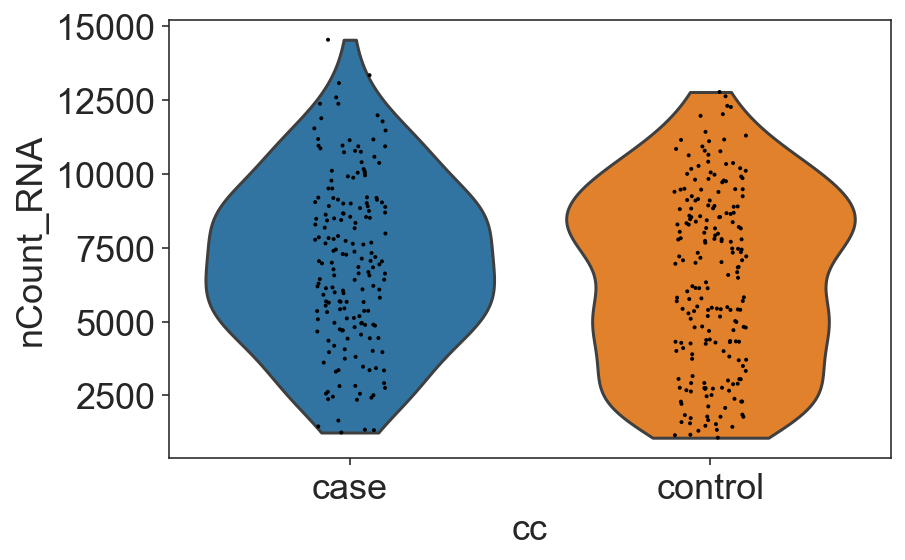

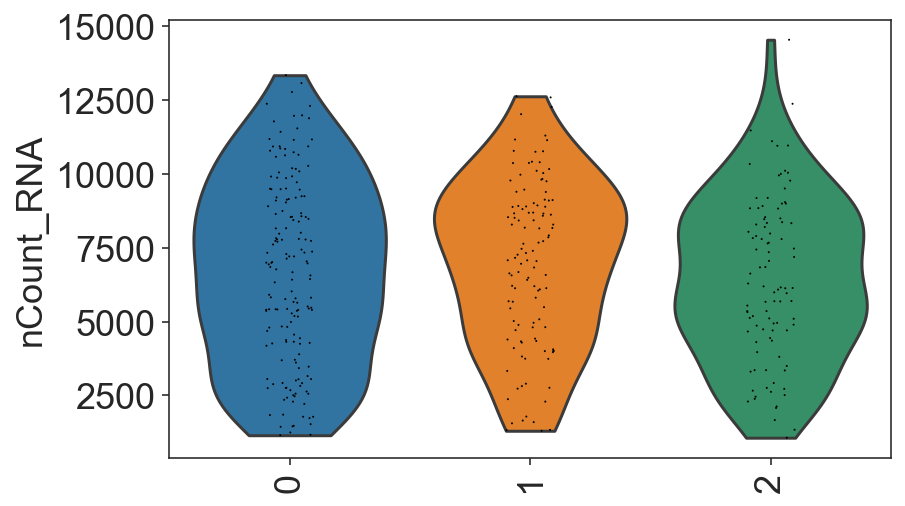

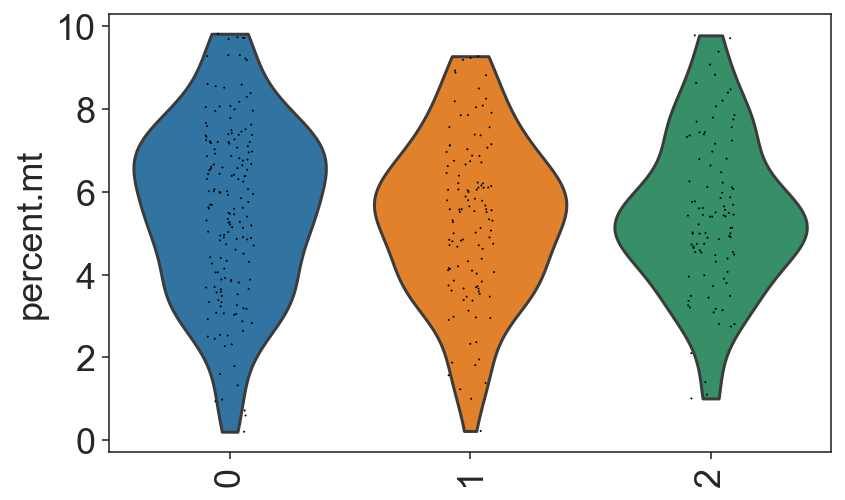

In [540]:
# subclustering quality plots
cluster_key="leiden" + str(res)

t1 = sc.pl.violin(adata, 'nCount_RNA', groupby='cc', size=2, log=False, cut=0, figsize=(2,2))
#t2 = sc.pl.violin(bdata, 'percent.mt', groupby='cc', figsize=(2,2))
t3 = sc.pl.violin(adata, 'nCount_RNA', groupby=cluster_key, rotation=90)
t4 = sc.pl.violin(adata, 'percent.mt', groupby=cluster_key, rotation=90)

<AxesSubplot:title={'center':'leiden0.2'}, xlabel='UMAP1', ylabel='UMAP2'>

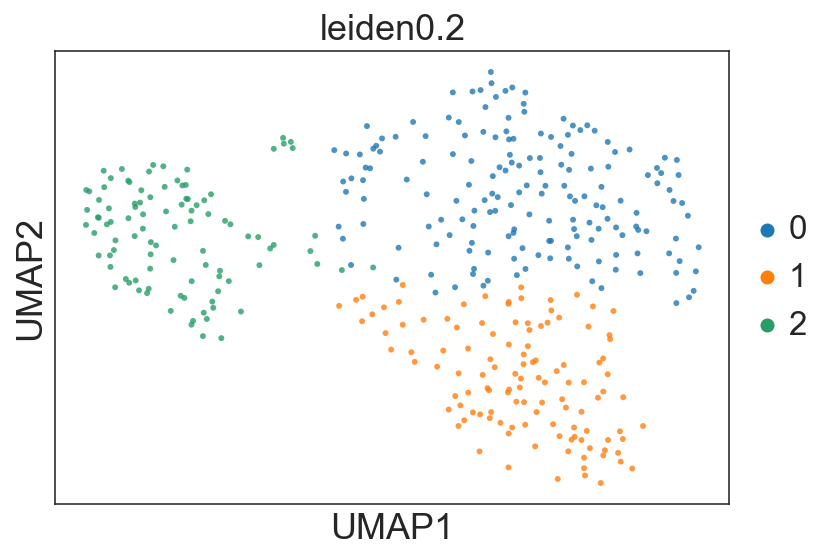

In [542]:
res = 0.2
sc.pl.embedding(adata, basis='umap', color='leiden'+str(res), ax=plt.gca(), show=False, alpha=0.8, size=35)

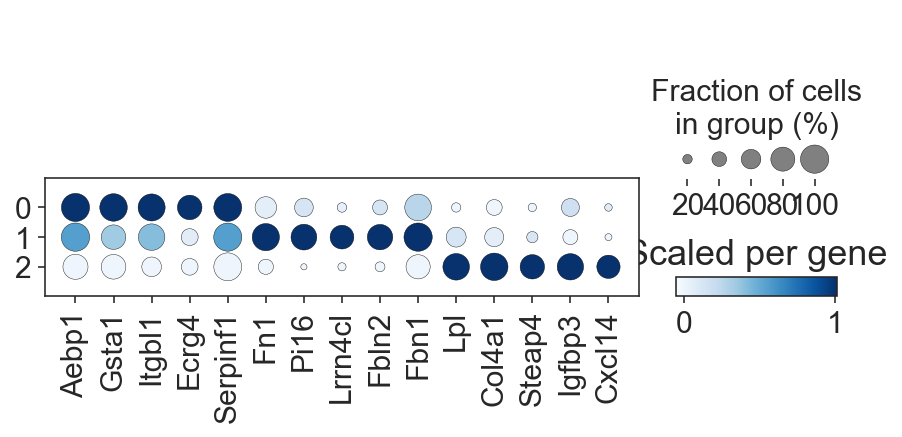

In [543]:
# marker genes
#res = 0.5

plt.rcParams.update({'font.size': 18})
n = 5

marker_key = 'rank_genes_groups' + str(res)
#marker_key = 'filter_rank_genes_groups' + str(res)

marker_genes = np.array(adata.uns[marker_key]['names'][:(n + 5)].tolist(), 
                        dtype=str).transpose()

unique_markers = []

for k in range(marker_genes.shape[0]):
    i = 0
    for g in marker_genes[k, :]:
        if i < n and g not in unique_markers and g != 'nan' and g != 'Malat1':  # exclude malat1
            unique_markers.append(g)
            i += 1

#unique_markers.append("PTPRC")

sc.pl.dotplot(adata,  var_names=unique_markers,groupby='leiden'+str(res), \
                                 use_raw=False, vmin=-0.05,
              vmax=1.01,cmap='bwr', standard_scale='var', show=False)

plt.title('Scaled per gene')
plt.show()